In [789]:
import pandas as pd
import seaborn as sns
import random
import itertools
import math
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
from mpl_toolkits.axes_grid1 import AxesGrid
from numpy import ma
%matplotlib inline

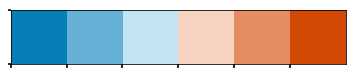

In [790]:
sns.palplot(sns.diverging_palette(240, 20, s=99, n=6))

In [791]:
# From https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

cm = matplotlib.cm.seismic
diverging_cmap = shiftedColorMap(cm, start = -1, midpoint=0, stop = 1)

In [792]:
POP_SIZE = 10
UPDATES = 100
GENOME_LENGTH = 5

#data = pd.DataFrame()


pop = []
for _ in range(POP_SIZE):
    pop.append(tuple([np.random.geometric(.5) for i in range(GENOME_LENGTH)]))


In [793]:
def lexicase_fitness(orgs):
    fitnesses = {org:0.0 for org in orgs}
    for order in itertools.permutations(range(len(orgs[0]))):
        remaining = orgs[:]
        for axis in order:
            best = 0
            winners = []
            for i in range(len(remaining)):
                if remaining[i][axis] > remaining[best][axis]:
                    best = i
                    winners = [remaining[i]]
                elif remaining[i][axis] == remaining[best][axis]:
                    winners.append(remaining[i])
            remaining = winners
            if len(remaining) == 1:
                break
        for org in remaining:
            fitnesses[org] += 1.0/len(remaining)
    
    for org in orgs:
        fitnesses[org] /= math.factorial(len(orgs[0]))
        
    return fitnesses

In [794]:
lexicase_fitness(pop)

{(1, 1, 2, 1, 1): 0.0,
 (1, 1, 2, 1, 2): 0.0,
 (1, 1, 5, 1, 1): 0.2,
 (1, 2, 1, 2, 1): 0.0,
 (1, 2, 4, 1, 4): 0.2,
 (1, 4, 3, 1, 3): 0.0,
 (2, 2, 1, 1, 2): 0.0,
 (2, 6, 1, 6, 1): 0.4,
 (4, 1, 1, 1, 2): 0.0016666666666666668}

In [795]:
def eco_ea_fitness(orgs):
    fitnesses = {org:1.0 for org in orgs}
    rel_fitnesses = {org:0.0 for org in orgs}
    
    for axis in range(len(orgs[0])):
        res = 2000
        count = 0
        for org in orgs:
            if org[axis] >= 3:
                count += 1
        if count > 0:
            res /= count
        for org in orgs:
            if org[axis] >= 3:
                fitnesses[org] *= 2**((.0025*res*(org[axis]/5.0)**2) - 1)
                #print(axis, org, 2**((.0025*res*(org[axis]/5.0)**2) - 1))
                
    for org in orgs:
        wins = 0
        ties = -1 #org will tie with itself
        fit = fitnesses[org]
        for val in fitnesses.values():
            if fit > val:
                wins += 1
            elif fit == val:
                ties += 1
        rel_fitnesses[org] = (2/len(orgs)) * (wins/(len(orgs) - 1) + .5*ties/(len(orgs) - 1))
        
    return rel_fitnesses
        
        

In [796]:

def sharing_fitness(orgs, sigma_share=8, alpha = 1):
    
    fitnesses = {org:1.0 for org in orgs}
    rel_fitnesses = {org:0.0 for org in orgs}
    
    for org in orgs:
        niche_count = 0.0
        for org2 in orgs:
            dist = sp.spatial.distance.euclidean(org, org2)
            if dist < sigma_share:
                niche_count += 1 - (dist/sigma_share)**alpha
        fit = sum(org)
        fit /= niche_count
        fitnesses[org] = fit
        
    for org in orgs:
        less = 0.0
        equal = 0.0
        greater = 0.0
        
        for org2 in orgs:
            if fitnesses[org2] < fitnesses[org]:
                less += 1
            elif fitnesses[org2] == fitnesses[org]:
                equal += 1
            else:
                greater += 1
                
        p_less = less/len(orgs)
        p_equal = equal/len(orgs)
        p_greater = greater/len(orgs)
        
        p_success = (2.0/len(orgs) * p_less) + (1.0/len(orgs) * p_equal)
        
        rel_fitnesses[org] = p_success
        
    return rel_fitnesses
        
    
        
    

In [797]:
eco_ea_fitness(pop)

{(1, 1, 2, 1, 1): 0.03333333333333333,
 (1, 1, 2, 1, 2): 0.03333333333333333,
 (1, 1, 5, 1, 1): 0.11111111111111112,
 (1, 2, 1, 2, 1): 0.03333333333333333,
 (1, 2, 4, 1, 4): 0.13333333333333333,
 (1, 4, 3, 1, 3): 0.08888888888888889,
 (2, 2, 1, 1, 2): 0.03333333333333333,
 (2, 6, 1, 6, 1): 0.17777777777777778,
 (4, 1, 1, 1, 2): 0.15555555555555556}

In [798]:
lexicase_fitness(pop)

{(1, 1, 2, 1, 1): 0.0,
 (1, 1, 2, 1, 2): 0.0,
 (1, 1, 5, 1, 1): 0.2,
 (1, 2, 1, 2, 1): 0.0,
 (1, 2, 4, 1, 4): 0.2,
 (1, 4, 3, 1, 3): 0.0,
 (2, 2, 1, 1, 2): 0.0,
 (2, 6, 1, 6, 1): 0.4,
 (4, 1, 1, 1, 2): 0.0016666666666666668}

In [799]:
sharing_fitness(pop, 10)

{(1, 1, 2, 1, 1): 0.010000000000000002,
 (1, 1, 2, 1, 2): 0.030000000000000006,
 (1, 1, 5, 1, 1): 0.13,
 (1, 2, 1, 2, 1): 0.05000000000000001,
 (1, 2, 4, 1, 4): 0.17000000000000004,
 (1, 4, 3, 1, 3): 0.15,
 (2, 2, 1, 1, 2): 0.07,
 (2, 6, 1, 6, 1): 0.19000000000000003,
 (4, 1, 1, 1, 2): 0.10000000000000002}

In [800]:
def calc_competition(orgs, fit_fun):
    fitnesses = fit_fun(orgs)
    
    effects = {o:{} for o in orgs}
    
    for org in orgs:
        curr = orgs[:]
        curr.remove(org)
        curr.append((0,0,0,0,0))

        new_fits = fit_fun(curr)
        
        for adj_org in orgs:
            if adj_org not in new_fits:
                continue
            if fitnesses[adj_org] - new_fits[adj_org] != 0:
                effects[org][adj_org] = {"weight":fitnesses[adj_org] - new_fits[adj_org]}
            
    return effects

In [801]:
lex = calc_competition(pop, lexicase_fitness)

eco = calc_competition(pop, eco_ea_fitness)

share = calc_competition(pop, sharing_fitness)

weights = []
for key in lex:
    for key2 in lex[key]:
        weights.extend(lex[key][key2].values())
for key in eco:
    for key2 in eco[key]:
        weights.extend(eco[key][key2].values())
for key in share:
    for key2 in share[key]:
        weights.extend(share[key][key2].values())

global_vmin = min(weights)
global_vmax = max(weights)

if abs(global_vmin) > abs(global_vmax):
    global_vmax = abs(global_vmin)
else:
    global_vmin = -1*global_vmax

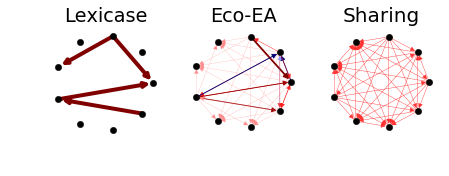

In [802]:

plt.figure(figsize=(7, 2))
plt.subplot(131)

lex_g = nx.DiGraph()
lex_g = nx.from_dict_of_dicts(lex, create_using=lex_g)

e=[d["weight"] for (u,v,d) in lex_g.edges(data=True)]

widths=[abs(d['weight'])*20 for (u,v,d) in lex_g.edges(data=True)]

nx.draw_shell(lex_g, node_color="black", node_size=40, edge_color=e, edge_vmin=global_vmin, edge_vmax=global_vmax,edge_cmap=matplotlib.cm.seismic_r, width=widths, with_labels=False)
plt.title("Lexicase")
plt.subplot(132)

eco_g = nx.DiGraph()
eco_g = nx.from_dict_of_dicts(eco, create_using=eco_g)

e=[d["weight"]*4 for (u,v,d) in eco_g.edges(data=True)]
widths=[abs(d['weight'])*20 for (u,v,d) in eco_g.edges(data=True)]

#e=["red" if d['weight'] < 0 else "blue" for (u,v,d) in eco_g.edges(data=True)]
#print(e)

nx.draw_shell(eco_g, edge_cmap=matplotlib.cm.seismic_r, node_size=40, width=widths, edge_vmin=global_vmin, edge_vmax=global_vmax, node_color="black", edge_color=e, with_labels=False)
plt.title("Eco-EA")
plt.subplot(133)

share_g = nx.DiGraph()
share_g = nx.from_dict_of_dicts(share, create_using=share_g)

e=[d["weight"] * 4 for (u,v,d) in share_g.edges(data=True)]
widths=[abs(d['weight'])*20 for (u,v,d) in share_g.edges(data=True)]

#e=["red" if d['weight'] < 0 else "blue" for (u,v,d) in share_g.edges(data=True)]

nx.draw_shell(share_g, node_size=40, node_color="black", edge_color=e, edge_cmap=matplotlib.cm.seismic_r, edge_vmin=global_vmin, edge_vmax=global_vmax, width=widths, with_labels=False)
plt.title("Sharing", fontsize=20)
plt.savefig("figs/interaction_networks.png", bbox_inches='tight', dpi=300)

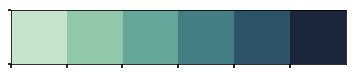

In [803]:
sns.palplot(sns.cubehelix_palette(rot=-.4))

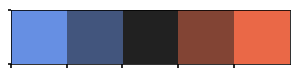

In [804]:
sns.palplot(sns.diverging_palette(255, 20, l=60, n=5, center="dark"))

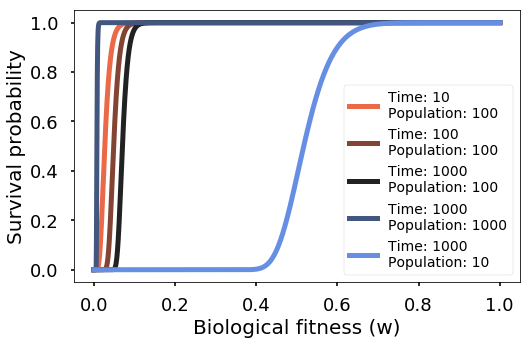

In [805]:
pal = sns.diverging_palette(255, 20, l=60, n=5, center="dark")

plt.figure(figsize=(8,5))

matplotlib.style.use("seaborn-poster")
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 

xvals = np.arange(0, 1, .0001)
y1 = (1 - (1-xvals)**10)**1000
y2 = (1 - (1-xvals)**100)**1000
y3 = (1 - (1-xvals)**1000)**1000
y4 = (1 - (1-xvals)**100)**10
y5 = (1 - (1-xvals)**100)**100

plt.plot(xvals, y4, color=pal[4], lw=5, label="Time: 10\nPopulation: 100")
plt.plot(xvals, y5, color=pal[3], lw=5, label="Time: 100\nPopulation: 100")
plt.plot(xvals, y2, color=pal[2], lw=5, label="Time: 1000\nPopulation: 100")
plt.plot(xvals, y3, color=pal[1], lw=5, label="Time: 1000\nPopulation: 1000")
plt.plot(xvals, y1, color=pal[0], lw=5, label="Time: 1000\nPopulation: 10")



plt.xlabel("Biological fitness (w)", fontsize=20)
plt.ylabel("Survival probability", fontsize=20)
plt.legend(fontsize=14, loc="best")

plt.savefig('figs/survival.png', bbox_inches='tight', dpi=300)

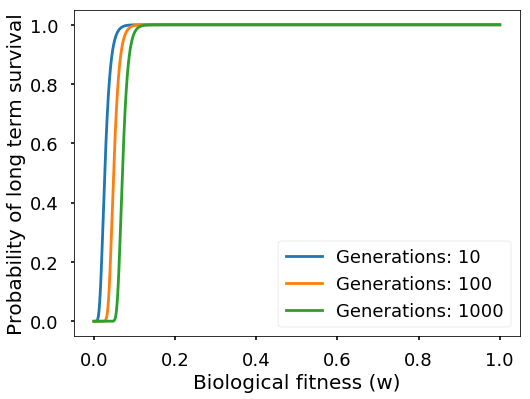

In [806]:
plt.figure(figsize=(8,6))
matplotlib.style.use("seaborn-poster")
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 
xvals = np.arange(0, 1, .0001)
y1 = (1 - (1-xvals)**100)**10
y2 = (1 - (1-xvals)**100)**100
y3 = (1 - (1-xvals)**100)**1000
plt.plot(xvals, y1, label="Generations: 10")
plt.plot(xvals, y2, label="Generations: 100")
plt.plot(xvals, y3, label="Generations: 1000")
plt.xlabel("Biological fitness (w)", fontsize=20)
plt.ylabel("Probability of long term survival", fontsize=20)
plt.legend(fontsize=18)

plt.savefig('figs/survival_generations.png', bbox_inches='tight', dpi=300)

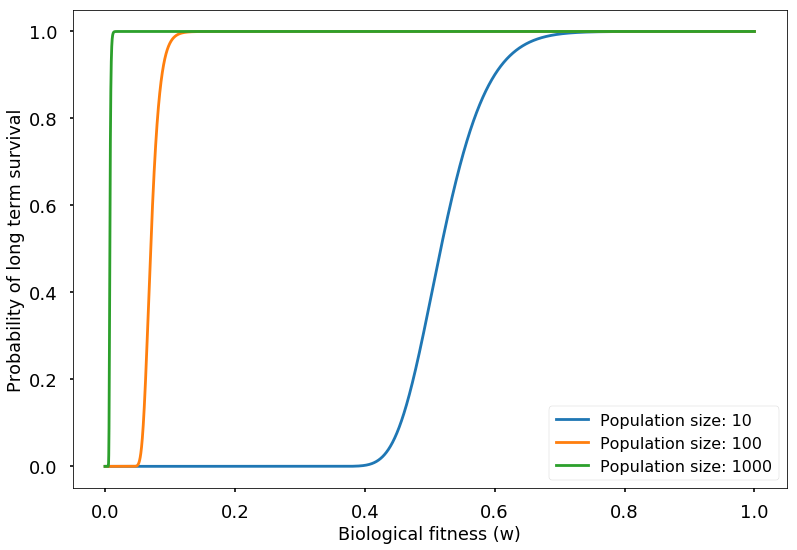

In [807]:
xvals = np.arange(0, 1, .0001)
y1 = (1 - (1-xvals)**10)**1000
y2 = (1 - (1-xvals)**100)**1000
y3 = (1 - (1-xvals)**1000)**1000
plt.plot(xvals, y1, label="Population size: 10")
plt.plot(xvals, y2, label="Population size: 100")
plt.plot(xvals, y3, label="Population size: 1000")
plt.xlabel("Biological fitness (w)")
plt.ylabel("Probability of long term survival")
plt.legend()

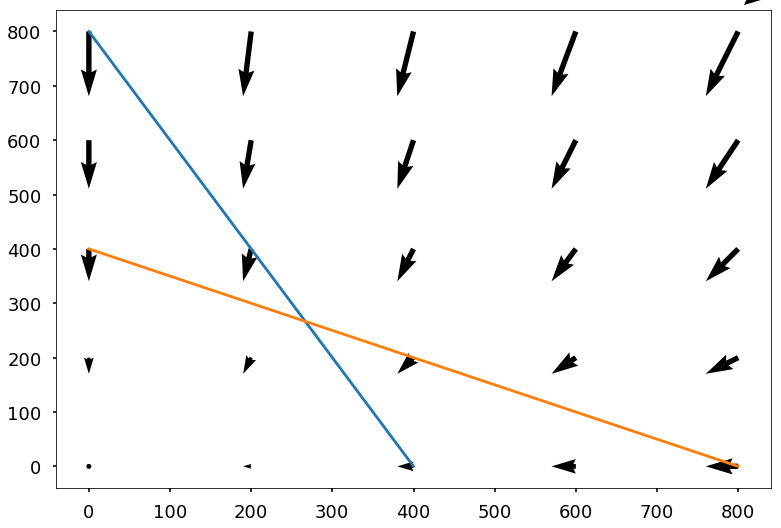

In [808]:
X, Y = np.meshgrid(np.arange(0, 1000, 200), np.arange(0, 1000, 200))
U = -.0025*.5*X 
V = -.0025*Y 
plt.plot([0, 400], [800, 0])
plt.plot([0, 800], [400, 0])
Q = plt.quiver(X, Y, U, V, units='width')
qk = plt.quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E',
                   coordinates='figure')

